# Exploring Amazon Images for Kaggle Competition

In [28]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plot
import seaborn as sns
sns.set_style("white")
%matplotlib inline

pal = sns.color_palette()

df_train = pd.read_csv('train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


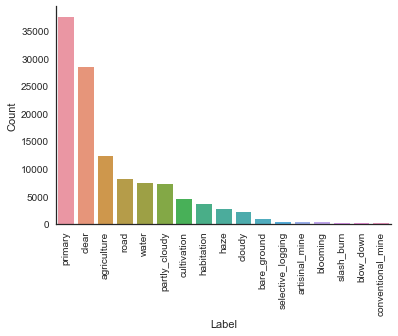

In [42]:
labels = df_train['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1
df_counts = pd.DataFrame(list(counts.items()),columns=["Label","Count"])
#df_counts.columns
df_counts = df_counts.sort_values("Count",ascending=False)
g = sns.barplot(x="Label",y="Count",data=df_counts)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set(ylabel="Count")
sns.despine()


In [43]:
# Co-occurence Matrix
com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

com
#data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
#layout=go.Layout(height=800, width=800, title='Co-occurence matrix of training labels')
#fig=dict(data=data, layout=layout)
#py.iplot(data, filename='train-com')

array([[  1.00000000e+00,   9.89988877e-01,   2.49165740e-01,
          0.00000000e+00,   2.27289581e-01,   4.78309232e-02,
          1.46088246e-01,   7.48980349e-02,   1.11234705e-03,
          0.00000000e+00,   0.00000000e+00,   7.41564702e-04,
          1.52020764e-02,   1.85391175e-03,   1.48312940e-03,
          1.85391175e-03,   0.00000000e+00],
       [  7.11753259e-02,   1.00000000e+00,   3.19142697e-01,
          7.37557647e-01,   1.86628635e-01,   9.24746088e-02,
          2.06008584e-01,   1.18758830e-01,   5.57140191e-03,
          0.00000000e+00,   1.91267027e-01,   2.50579799e-03,
          1.82070216e-02,   8.63700584e-03,   8.85026524e-03,
          9.06352464e-03,   2.61242769e-03],
       [  5.45676005e-02,   9.72147787e-01,   1.00000000e+00,
          7.42996346e-01,   2.20219245e-01,   2.22249289e-01,
          4.89971579e-01,   2.74218433e-01,   9.66301259e-03,
          0.00000000e+00,   2.02436054e-01,   1.94884287e-03,
          1.82704019e-02,   3.08566788e-03